In [4]:
import os
import networkx as nx   # https://networkx.org/documentation/stable/tutorial.html
import pandas as pd
data_dir = os.path.expanduser("/Users/jun/workspace/cora_dataset")   # https://graphsandnetworks.com/the-cora-dataset/

In [5]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

print(edgelist)
print(type(edgelist))

# E = (target, source)

      target   source  label
0         35     1033  cites
1         35   103482  cites
2         35   103515  cites
3         35  1050679  cites
4         35  1103960  cites
...      ...      ...    ...
5424  853116    19621  cites
5425  853116   853155  cites
5426  853118  1140289  cites
5427  853155   853118  cites
5428  954315  1155073  cites

[5429 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]   # <class 'list'>
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

node_data

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
117328,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [7]:
targets = node_data.index

In [8]:
# create a networkx graph object
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")   # Gnx : Graph with 2708 nodes and 5278 edges
nx.set_node_attributes(Gnx, "paper", "label")

In [9]:
import numpy as np
import random
import argparse
import pickle
import torch
from gensim.models import Word2Vec   # https://radimrehurek.com/gensim/
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import json
from tqdm import tqdm

In [10]:
# Reference : https://github.com/Manu-Fraile/Network-Representation-Learning/blob/master/DeepWalk/main.py
# https://github.com/rlagywns0213/2021_Summer_Internship/blob/main/Graph%20Neural%20Network/RandomWalk/Deepwalk/train.py
# sg parameter if 1 skip gram for Word2Vec https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# hs parameter if 1 hierarchical softmax
class DeepWalk(torch.nn.Module):
    def __init__(self, graph, window_size=10, dim=64, gamma=30, walk_length=6):
        super(DeepWalk, self).__init__()
        self.G = graph  
        self.w = window_size
        self.d = dim    # embedding size
        self.g = gamma    # walks per vertex
        self.t = walk_length
        self.wvmodel = None

    def randomWalk(self, start_node):
        walk = []
        current_node = start_node 
        walk.append(str(start_node))
        for _ in range(self.t - 1):
            neighbors = list(self.G.edges([current_node])) 
            if (len(neighbors) > 0): 
                random_edge = random.choice(neighbors)
            if (random_edge[0] == current_node): 
                current_node = random_edge[1] 
            else : 
                current_node = random_edge[0] 
            walk.append(str(current_node))
        return walk

    def fit(self): 
        walks = []
        nodes = list(self.G.nodes())
        for _ in tqdm(range(self.g)): 
            random.shuffle(nodes)
            for node in nodes: 
                walks.append(self.randomWalk(node)) 
        #SkipGram
        self.wvmodel = Word2Vec(walks, vector_size=self.d, window=self.w, sg=1, hs=1)

    def get_wvmodel(self): 
        return self.wvmodel

In [11]:
w = DeepWalk(Gnx, 10, 64, 30, 10)

In [12]:
w.fit()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.61it/s]


In [13]:
print(node_data.loc[[int(x) for x in targets],'subject'])

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object


In [14]:
wvmodel = w.get_wvmodel()
word_vectors = wvmodel.wv
y = node_data.loc[[int(x) for x in targets],'subject']
print(y)
# X_dw = []
# print(word_vectors['31336'])
# for i in y.index:
#     X_dw.append(word_vectors[str(i)])
X_dw = [word_vectors[str(i)] for i in y.index]
print(X_dw)

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object
[array([ 0.78474486, -1.4314988 , -0.42017993,  0.8347086 , -0.53760725,
        0.49594113,  0.2095282 ,  0.14566182, -0.3389665 ,  0.21435109,
        0.17670177,  0.53857446, -0.1247493 , -0.2412893 ,  0.22482586,
        1.2893522 , -1.2242501 , -0.28067583, -0.6047954 , -1.231229  ,
        0.48719805,  0.14173234,  0.6414232 , -1.3775179 ,  0.38310078,
       -0.6109781 ,  0.96537733, -1.1976103 ,  0.2007158 ,  0.22829954,
        0.3869183 , -1.1643902 , -0.43204698, -0.09235904, -0.09246588,
       -1.0682791 , -0.09709471, -0.8118353 ,  0.27750987, -0.4885798 ,
      

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix


def classify(word_vectors, tr=0.8):   # tr : Training ratio
    y = node_data.loc[[int(x) for x in targets],'subject']
    X = [word_vectors[str(idx)] for idx in y.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-tr), random_state=5)
    rf = KNeighborsClassifier()
    rf.fit(X_train, y_train)
    y_predict = rf.predict(X_test)
    
    #evaluate
    f1_microscore = f1_score(y_test, y_predict, average='micro')
    return f1_microscore

def test(dim=64, tr=0.8, gamma=10):
    w = DeepWalk(Gnx, 5, dim, gamma, 10)
    w.fit()
    word_vectors = w.get_wvmodel().wv
    return classify(word_vectors, tr)
    

In [16]:
dims = [1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]
trs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# dim 바꿔서 비교
# default dim 64, tr 0.8, gamma 30

res_list = []
for dim in dims:   # dimmension 계산
    res = test(dim, 0.8, 30)
    res_list.append(res)
data_dim = {'dimension': dims,
                'f1_microscore': res_list}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.53it/s]


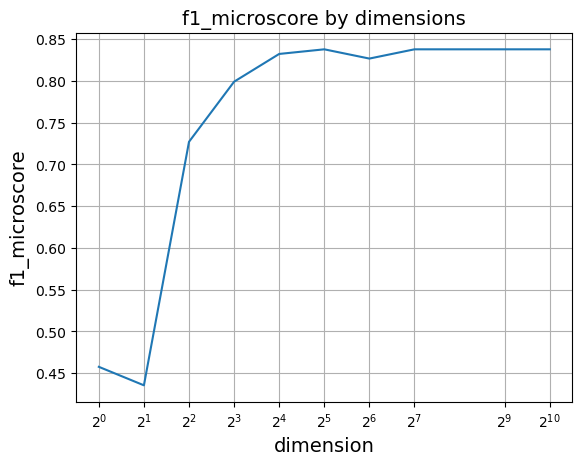

In [17]:
df = pd.DataFrame(data_dim)   # dimension에 따른 f1 score그래프

plt.plot(df['dimension'], df['f1_microscore'])
plt.title('f1_microscore by dimensions', fontsize=14)
plt.xlabel('dimension', fontsize=14)
plt.ylabel('f1_microscore', fontsize=14)
plt.xscale('log', base=2)
plt.xticks([1, 2, 4, 8, 16, 32, 64, 128, 512, 1024])
plt.grid(True)
plt.show()

In [103]:
dims = [1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]
trs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# tr 바꿔서 비교
# default dim 64, tr 0.8, gamma 30

res_list = []
for tr in trs:   # tr 계산
    res = test(64, tr, 30)
    res_list.append(res)

data_tr = {'train ratio': trs,
                'f1_microscore': res_list}


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.69it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.25it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.99it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.86it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.40it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.05it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.21it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.79it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.78it/s]


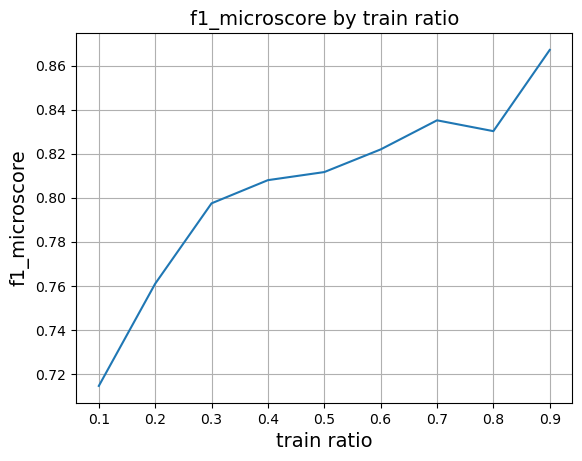

In [104]:
df = pd.DataFrame(data_tr)   # train ration에 따른 f1 score그래프

plt.plot(df['train ratio'], df['f1_microscore'])
plt.title('f1_microscore by train ratio', fontsize=14)
plt.xlabel('train ratio', fontsize=14)
plt.ylabel('f1_microscore', fontsize=14)
plt.xticks(trs)
plt.grid(True)
plt.show()

In [107]:
dims = [1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]
trs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# gamma 바꿔서 비교
# default dim 64, tr 0.8, gamma 30

res_list = []
for gamma in gammas:   # gamma 계산
    res = test(64, 0.8, gamma)
    res_list.append(res)
data_gamma = {'gamma': gammas, 'f1_microscore': res_list}


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.38it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.94it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.28it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.01it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.58it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.60it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 10.86it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:07<00:00, 10.61it/s]


starting 2708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:08<00:00, 10.21it/s]


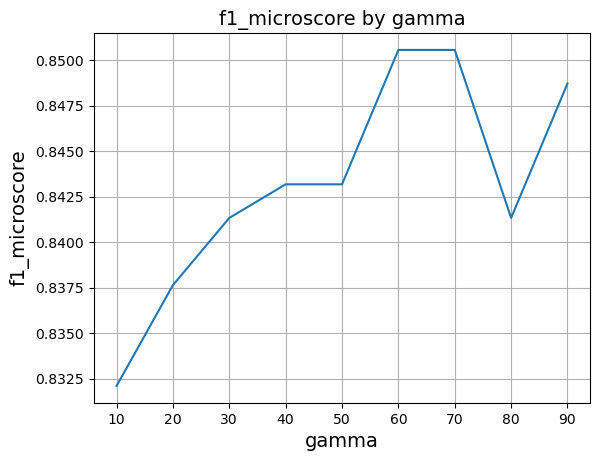

In [108]:
df = pd.DataFrame(data_gamma)   # gamma에 따른 f1 score그래프

plt.plot(df['gamma'], df['f1_microscore'])
plt.title('f1_microscore by gamma', fontsize=14)
plt.xlabel('gamma', fontsize=14)
plt.ylabel('f1_microscore', fontsize=14)
plt.xticks(gammas)
plt.grid(True)
plt.show()